In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr

def get_cluster_pct_NMD(clu, df_clu):
    '''
    Get percentage of NMD junction reads in an intron cluster.
    '''
    pct_NMD = []
    for df in df_clu.loc[df_clu.cluster.isin(clu)].groupby('cluster'):
        if df[1].isNMD.all():
            pct_NMD.append(1)
        elif not df[1].isNMD.any():
            pct_NMD.append(0)
        elif df[1][chRNA_samples].sum().sum() > 0:
            NMD_counts = df[1].loc[df[1].isNMD][chRNA_samples].sum().sum()
            total_counts = df[1][chRNA_samples].sum().sum()
            pct_NMD.append(NMD_counts/total_counts)
    return pct_NMD


def plot_cumulative(x, steps = 100):
    '''
    Function to get cumulative distribution.
    '''
    x = np.array(x)
    X = np.linspace(np.min(x), np.max(x), steps)
    y = [np.mean(x<=z) for z in X]
    return X, y

def get_junction_counts(phenotype='chRNA.Expression.Splicing', subset_samples=[], remove_sample=None):
    
    '''
    Get junction read counts from leafcutter tables.
    '''
    
    template = '../code/SplicingAnalysis/leafcutter/clustering/autosomes/leafcutter_perind.counts.gz.{Phenotype}.gz'
    counts = pd.read_csv(template.format(Phenotype=phenotype), sep=' ')
    
    if len(subset_samples) > 0:
        counts = counts[['chrom'] + list(subset_samples)]
        counts.columns = ['cluster_id'] + list(subset_samples)
        
    if remove_sample:
        counts = counts.drop(remove_sample, axis=1)

    
    
    samples = list(counts.columns[1:])
    counts.columns = ['cluster_id'] + samples

    counts[['chrom', 'start', 'end', 'cluster']] = counts['cluster_id'].str.split(':', 3, expand=True)

    counts['strand'] = [x.split('_')[-1] for x in counts.cluster]
    counts['intron'] = counts.chrom + ':' + counts.start.astype(str)+ ':' + counts.end.astype(str) + ':' + counts.strand

    for sample in samples:
        counts[[sample, sample+'_total']] = counts[sample].str.split('/', 1, expand=True)

    counts = counts[['chrom', 'start', 'end', 'cluster', 'intron', 'strand'] + samples]

    counts['start'] = counts['start'].astype(int)
    counts['end'] = counts['end'].astype(int)
    counts[samples] = counts[samples].astype(int)
    
    return counts, samples

def get_series_quantile(series, gene_list=None, quant=4):
    
    '''
    Split pandas series by quantiles. Number of quntiles defined by quant (default = 4).
    Output is a list containing the index of the series, split in increasing quantiles.
    '''
    
    if not gene_list is None:
        series = series.loc[gene_list].dropna()
    
    q = 1/quant
    
    seriesQ_list = []
    
    for i in range(quant):
        Qi = series.quantile(q*i)
        Qi2 = series.quantile(q*(i+1))
        if i == 0:
            Qi -= 1
        if i == (quant-1):
            Qi2 += 1
        seriesQi = series.loc[(series >= Qi) & (series < Qi2)].index
        
        seriesQ_list.append(seriesQi)
        
    return seriesQ_list
    
RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)
    
clusters, chRNA_samples = get_junction_counts(phenotype='chRNA.Expression.Splicing', remove_sample='NA18855')
intron_coords = clusters.chrom + ':' + clusters.start.astype(str) + '-' + clusters.end.astype(str) + ':' + clusters.strand
clusters['intron_coords'] = intron_coords

intron_annot = pd.read_csv('/project2/yangili1/bjf79/ChromatinSplicingQTLs/data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)

clusters = clusters.merge(intron_annot.loc[intron_annot.gene.isin(RPKM.index), ['junction', 'SuperAnnotation']], 
               left_on = 'intron', right_on='junction')
clusters = clusters.assign(intron_length=lambda x: x.end - x.start)

clusters['isNMD'] = np.array(
    clusters.SuperAnnotation.isin(['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene'])
)

clu_list = []
intron_len = []
for df in clusters.loc[clusters.SuperAnnotation.isin(
    ['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']
)].groupby('cluster'):
    len_top_pc = df[1].iloc[df[1][chRNA_samples].sum(axis=1).argmax()].intron_length
    clu_list.append(df[0])
    intron_len.append(len_top_pc)
    
df_clu = pd.DataFrame()
df_clu['intron_length'] = intron_len
df_clu.index = clu_list

In [7]:
from decimal import Decimal 

def get_cluster_pct_NMD_clu(clu, df_clu):
    pct_NMD = []
    clu_list = []
    for df in tqdm(df_clu.loc[df_clu.cluster.isin(clu)].groupby('cluster')):
        if df[1].isNMD.all():
            pct_NMD.append(1)
            clu_list.append(df[0])
        elif not df[1].isNMD.any():
            pct_NMD.append(0)
            clu_list.append(df[0])
        elif df[1][chRNA_samples].sum().sum() > 0:
            NMD_counts = df[1].loc[df[1].isNMD][chRNA_samples].sum().sum()
            total_counts = df[1][chRNA_samples].sum().sum()
            pct_NMD.append(NMD_counts/total_counts)
            clu_list.append(df[0])
    return pct_NMD, clu_list

pct_NMD_all, clu_list = get_cluster_pct_NMD_clu(df_clu.index, clusters)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31844/31844 [01:21<00:00, 392.25it/s]


In [10]:
def annotate_pval(X, Y, ax, xy = (0.05, 0.1), col='black'):
    
    corr_label = 'Spearman r'
    corr = spearmanr(X, Y)

    str_cor = "{:.2f}".format(corr[0])#str(round(corr[0], 2))
    str_pval = print_pval(corr[1])

    legend = corr_label + ' = ' + str_cor + '\n' + 'pval = ' + str_pval
    ax.annotate(legend, xy=xy, xycoords='axes fraction', c=col)
    
def print_pval(pval):
    if pval > 0.01:
        str_pval = str(round(pval, 2))
    else:
        str_pval = '%.2E' % Decimal(pval)
    return str_pval

def get_series_range(series, range_list):

        
    seriesQ_list = []
    
    seriesQ1 = series.loc[(series <= range_list[0])].index
    seriesQ_list.append(seriesQ1)
    seriesQn = series.loc[(series > range_list[-1])].index
    
    for i in range(len(range_list)-1):
        Qi = range_list[i]
        Qi2 = range_list[i+1]
        
        seriesQi = series.loc[(series > Qi) & (series <= Qi2)].index
        
        seriesQ_list.append(seriesQi)
        
    seriesQ_list.append(seriesQn)
        
    return seriesQ_list

clu_10 = get_series_range(df_clu.intron_length, [1000, 5000, 20000, 50000])

X_list = []
y_list = []
for i in range(len(clu_10)):
    pct_NMD = get_cluster_pct_NMD(clu_10[i], clusters)
    X, y =  plot_cumulative(pct_NMD, steps=1000)
    X_list.append(X)
    y_list.append(y)


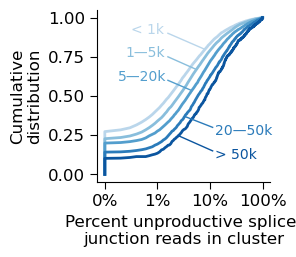

In [11]:
plt.rcParams['legend.title_fontsize'] = 12

colores = sns.color_palette("Blues", 6)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

label_list = ['< 1k', '1—5k', '5—20k', '20—50k', '> 50k']

for i in range(len(clu_10)):
    X = X_list[i]
    y = y_list[i]
    label = label_list[i]
    ax.plot([-3] + list(np.log10(np.array(X)[1:])), [0]+list(y[1:]), c=colores[i+1], linewidth = 2, label=label)

ax.set_ylabel('Cumulative\ndistribution', size=12)
ax.set_xticks([-3, -2, -1, 0])
ax.set_xticklabels(['0%', '1%', '10%', '100%'])

ax.tick_params(length=5, labelsize=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(-2.5, 0.9, label_list[0], c=colores[1])
ax.plot([-1.8, np.log10(X_list[0][80])], [0.9, y_list[0][80]], linewidth=1, c=colores[1])

ax.text(-2.6, 0.75, label_list[1], c=colores[2])
ax.plot([-1.8, np.log10(X_list[1][55])], [0.75, y_list[1][55]], linewidth=1, c=colores[2])

ax.text(-2.75, 0.6, label_list[2], c=colores[3])
ax.plot([-1.8, np.log10(X_list[2][45])], [0.6, y_list[2][45]], linewidth=1, c=colores[3])

ax.text(-0.9, 0.25, label_list[3], c=colores[4])
ax.plot([-0.95, np.log10(X_list[3][33])], [0.3, y_list[3][33]], linewidth=1, c=colores[4])

ax.text(-0.9, 0.1, label_list[4], c=colores[5])
ax.plot([-0.95, np.log10(X_list[4][25])], [0.15, y_list[4][25]], linewidth=1, c=colores[5])

ax.set_xlabel('Percent unproductive splice \njunction reads in cluster', size=12)#"Max. prot. coding intron length", size=12)

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_length_vs_NMD_no_legend.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_length_vs_NMD_no_legend.png', dpi=300, bbox_inches='tight',)

# By RPKM

In [19]:
long_table = pd.read_csv(
    '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
)
long_table_ = long_table.loc[long_table.RepNumber == '1.junc'].drop_duplicates()
long_table = long_table_.loc[long_table_.Dataset=='chRNA.Expression.Splicing'].copy()
del long_table_
long_table = long_table.loc[~((long_table.IndID == 'NA18855') & (long_table.Dataset == 'chRNA.Expression.Splicing'))]

long_table.stop += 1


long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'stop', 'strand'],
                right_on=['chrom', 'start', 'end', 'strand'])

long_table['gene'] = [x.split('.')[0] for x in long_table.gene]

RPKM.index = [x.split('.')[0] for x in RPKM.index]

shared_genes = pd.Index(long_table.gene.unique()).intersection(RPKM.index)
long_table_sum = long_table.groupby(['gene', 'symbol', 'junction', 'NewAnnotation', 'SuperAnnotation']
                                   ).Count.sum().reset_index()

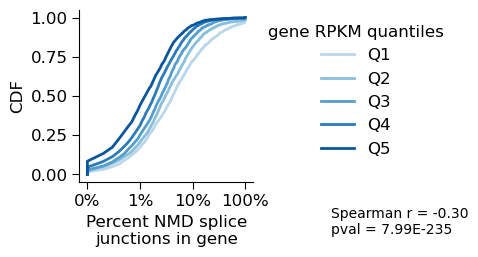

In [20]:
NMD = ['UnannotatedJunc_UnproductiveCodingGene', 'AnnotatedJunc_UnproductiveCodingGene']
NMD_sum = long_table_sum.loc[long_table_sum.SuperAnnotation.isin(NMD)].groupby('gene').Count.sum()
total_sum = long_table_sum.groupby('gene').Count.sum()
NMD_pct_gene = NMD_sum.loc[shared_genes.intersection(NMD_sum.index)]/total_sum.loc[shared_genes.intersection(NMD_sum.index)]

RPKM_q = get_series_quantile(RPKM.loc[shared_genes.intersection(NMD_sum.index), chRNA_samples].median(axis=1), quant=5)

colores = sns.color_palette("Blues", 6)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

X_list2 = []
y_list2 = []

for i in range(len(RPKM_q)):
    pct_NMD = np.array(NMD_pct_gene.loc[RPKM_q[i]])
    X, y =  plot_cumulative(pct_NMD, steps=1000)
    X_list2.append(X)
    y_list2.append(y)
    if i == 0:
        label = 'Q1' 
    elif i == 4:
        label = 'Q5'
    else:
        label = 'Q' + str(i+1)
    ax.plot([-3] + list(np.log10(np.array(X)[1:])), [0]+list(y[1:]), c=colores[i+1], linewidth = 2, label=label)

ax.set_xlabel('Percent NMD splice\njunctions in gene', size=12)#"Max. prot. coding intron length", size=12)
ax.legend(frameon=False, title='gene RPKM quantiles', bbox_to_anchor=(1, 1), fontsize=12)
ax.set_ylabel('CDF', size=12)
ax.set_xticks([-3, -2, -1, 0])
ax.set_xticklabels(['0%', '1%', '10%', '100%'])

ax.tick_params(length=5, labelsize=12)


annotate_pval(RPKM.loc[shared_genes.intersection(NMD_sum.index), chRNA_samples].median(axis=1), 
              NMD_pct_gene.loc[shared_genes.intersection(NMD_sum.index)], 
              ax, xy = (1.45, -0.3), col='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim([-3, 53])

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_RPKM_vs_NMD.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_RPKM_vs_NMD.png', dpi=300, bbox_inches='tight',)

# Evolutionary constraints

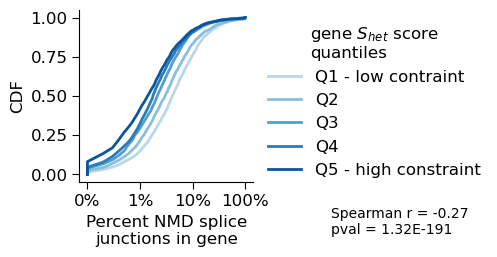

In [21]:
scores = pd.read_csv('../../media-1.tsv', sep='\t', index_col=0)

s_het_q = get_series_quantile(scores.loc[scores.index.intersection(NMD_pct_gene.index)].post_mean, quant=5)

colores = sns.color_palette("Blues", 6)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

for i in range(len(s_het_q)):
    pct_NMD = np.array(NMD_pct_gene.loc[s_het_q[i]])
    X, y =  plot_cumulative(pct_NMD, steps=1000)
    if i == 0:
        label = 'Q1 - low contraint' 
    elif i == 4:
        label = 'Q5 - high constraint'
    else:
        label = 'Q' + str(i+1)
    ax.plot([-3] + list(np.log10(np.array(X)[1:])), [0]+list(y[1:]), c=colores[i+1], linewidth = 2, label=label)

ax.set_xlabel('Percent NMD splice\njunctions in gene', size=12)#"Max. prot. coding intron length", size=12)
ax.set_ylabel('CDF', size=12)
ax.set_xticks([-3, -2, -1, 0])
ax.set_xticklabels(['0%', '1%', '10%', '100%'])

ax.legend(frameon=False, title='gene $S_{het}$ score\nquantiles', bbox_to_anchor=(1, 1), fontsize=12)

annotate_pval(np.log10(scores.loc[scores.index.intersection(NMD_pct_gene.index)].post_mean),
            np.log10(NMD_pct_gene.loc[scores.index.intersection(NMD_pct_gene.index)]), ax, xy = (1.45, -0.3), col='black')

ax.tick_params(length=5, labelsize=12)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim([-3, 53])

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_S_het_score_vs_NMD.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_S_het_score_vs_NMD.png', dpi=300, bbox_inches='tight',)

# MaxEntScan

In [59]:
fp_scores = pd.read_csv('../code/SplicingAnalysis/MaxEntScan/Annotation/FivePrime.score.tab.gz', sep='\t',
                       names = ['intron_id', 'sequence', 'MaxEntScan'])

fp_scores[['intron', 'ss_coords']] = fp_scores.intron_id.str.split('::', 1, expand=True)

intron_annot['gene'] = [x.split('.')[0] for x in intron_annot.gene]

chRNA_clusters = clusters.merge(fp_scores, left_on='intron', right_on='intron').merge(intron_annot[['chrom', 'start', 'end', 'strand', 'junction', 'gene']], 
                                                                          left_on=['chrom', 'start', 'end', 'strand', 'intron'],
                                                                          right_on = ['chrom', 'start', 'end', 'strand', 'junction'])

chRNA_clusters = chRNA_clusters.loc[chRNA_clusters.gene.isin(expressed_genes.gene)]

chRNA_clusters['isPC'] = list(chRNA_clusters.SuperAnnotation.isin(['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']))
chRNA_clusters['isNMD'] = list(chRNA_clusters.SuperAnnotation.isin(['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene']))

NMD_clusters = chRNA_clusters.groupby('cluster').isNMD.any().reset_index()
NMD_clusters.columns = ['cluster', 'isNMD_cluster']

chRNA_clusters = chRNA_clusters.merge(NMD_clusters, left_on='cluster', right_on='cluster')

In [62]:
def get_NMD_ratio(clu, chRNA_samples):
    
    if clu.isNMD.any():
    
        NMD_reads = int(clu.loc[clu.isNMD, chRNA_samples].sum().sum())
        SS_type = 'alt_NMD'
        
    else:
        NMD_reads = 0
        SS_type = 'alt_PC'
        
    PC_reads = int(clu.loc[clu.isPC, chRNA_samples].sum().sum())
    
    MES = clu.MaxEntScan.max()
    
    total_reads = (NMD_reads + PC_reads)
    NMD_ratio = NMD_reads / total_reads
    
    return SS_type, total_reads, NMD_ratio, MES

In [63]:
junc_name = []
total_reads = []
NMD_ratio = []
MES_5p = []
SS_type = []

for clu in tqdm(chRNA_clusters.loc[chRNA_clusters.strand == '+'].groupby(['chrom', 'start', 'cluster'])):
    
    if clu[1][chRNA_samples].sum().sum() == 0:
        continue
    
#     if clu[1].isPC.any() and (clu[1].shape[0] == 1):
#         SS_type.append('const_PC')
#         NMD_ratio.append(0)
#         MES_5p.append(float(clu[1].MaxEntScan))
#         total_reads.append(clu[1][chRNA_samples].sum().sum())
        
    
    elif clu[1].isPC.any() and (clu[1].shape[0] > 1):
        
        junc_name_ = ':'.join([clu[0][0], str(clu[0][1]), '+'])
        
        SS_type_, total_reads_, NMD_ratio_, MES_5p_ = get_NMD_ratio(clu[1], chRNA_samples)
        SS_type.append(SS_type_)
        total_reads.append(total_reads_)
        NMD_ratio.append(NMD_ratio_)
        MES_5p.append(MES_5p_)
        junc_name.append(junc_name_)
        
for clu in tqdm(chRNA_clusters.loc[chRNA_clusters.strand == '-'].groupby(['chrom', 'end', 'cluster'])):
    
    if clu[1][chRNA_samples].sum().sum() == 0:
        continue
    
#     if clu[1].isPC.any() and (clu[1].shape[0] == 1):
#         SS_type.append('const_PC')
#         NMD_ratio.append(0)
#         MES_5p.append(float(clu[1].MaxEntScan))
#         total_reads.append(clu[1][chRNA_samples].sum().sum())
    
    elif clu[1].isPC.any() and (clu[1].shape[0] > 1):
        junc_name_ = ':'.join([clu[0][0], str(clu[0][1]), '-'])
        SS_type_, total_reads_, NMD_ratio_, MES_5p_ = get_NMD_ratio(clu[1], chRNA_samples)
        SS_type.append(SS_type_)
        total_reads.append(total_reads_)
        NMD_ratio.append(NMD_ratio_)
        MES_5p.append(MES_5p_)
        junc_name.append(junc_name_)
        
df_5p = pd.DataFrame()
df_5p['total_reads'] = total_reads
df_5p['NMD_ratio'] = NMD_ratio
df_5p['MES_5p'] = MES_5p
df_5p['SS_type'] = SS_type
df_5p.index = junc_name

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38792/38792 [01:19<00:00, 486.25it/s]


In [64]:
df_5p = df_5p.loc[df_5p.SS_type == 'alt_NMD']

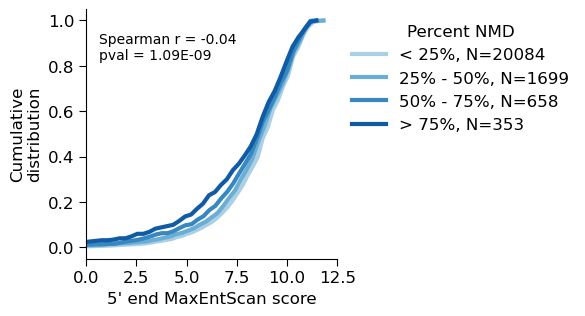

In [66]:
plt.rcParams['legend.title_fontsize'] = 12

colores = sns.color_palette("Blues", 5)
X, Y = plot_cumulative(np.array(df_5p.loc[(df_5p.NMD_ratio <= 0.25)].MES_5p))
N = len(np.array(df_5p.loc[(df_5p.NMD_ratio <= 0.25)].MES_5p))

X_, Y_ = plot_cumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.25) & (df_5p.NMD_ratio <= 0.5)].MES_5p))
N_ = len(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.25) & (df_5p.NMD_ratio <= 0.5)].MES_5p))

X__, Y__ = plot_cumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.5) & (df_5p.NMD_ratio <= 0.75)].MES_5p))
N__ = len(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.5) & (df_5p.NMD_ratio <= 0.75)].MES_5p))

X___, Y___ = plot_cumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.75)].MES_5p))
N___ = len(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.75)].MES_5p))

fig, ax = plt.subplots(figsize=(3.24, 3.24))

ax.plot(X, Y, c=colores[1], linewidth = 3, label='< 25%, N='+str(N))
ax.plot(X_, Y_, c=colores[2], linewidth = 3, label='25% - 50%, N='+str(N_))
ax.plot(X__, Y__, c=colores[3], linewidth = 3, label='50% - 75%, N='+str(N__))
ax.plot(X___, Y___, c=colores[4], linewidth = 3, label='> 75%, N='+str(N___))
ax.set_xlim([0, 12.5])
ax.legend(frameon=False, title='Percent NMD', bbox_to_anchor=(1, 1), fontsize=12)

# ax.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=12)

ax.set_xlabel("5' end MaxEntScan score", size=12)
ax.set_ylabel('Cumulative\ndistribution', size=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=12)


annotate_pval(df_5p.NMD_ratio, df_5p.MES_5p, ax, xy = (0.05, 0.8), col='black')

fig_dir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(fig_dir + 'Supplement_MaxEntScan_FivePrime.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(fig_dir + 'Supplement_MaxEntScan_FivePrime.png', dpi=300, bbox_inches='tight',)

In [70]:
fp_scores = pd.read_csv('../code/SplicingAnalysis/MaxEntScan/Annotation/ThreePrime.score.tab.gz', sep='\t',
                       names = ['intron_id', 'sequence', 'MaxEntScan'])

fp_scores[['intron', 'ss_coords']] = fp_scores.intron_id.str.split('::', 1, expand=True)


chRNA_clusters = clusters.merge(fp_scores, left_on='intron', right_on='intron').merge(intron_annot[['chrom', 'start', 'end', 'strand', 'junction', 'gene']], 
                                                                          left_on=['chrom', 'start', 'end', 'strand', 'intron'],
                                                                          right_on = ['chrom', 'start', 'end', 'strand', 'junction'])

chRNA_clusters = chRNA_clusters.loc[chRNA_clusters.gene.isin(expressed_genes.gene)]

chRNA_clusters['isPC'] = list(chRNA_clusters.SuperAnnotation.isin(['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']))
chRNA_clusters['isNMD'] = list(chRNA_clusters.SuperAnnotation.isin(['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene']))

NMD_clusters = chRNA_clusters.groupby('cluster').isNMD.any().reset_index()
NMD_clusters.columns = ['cluster', 'isNMD_cluster']

chRNA_clusters = chRNA_clusters.merge(NMD_clusters, left_on='cluster', right_on='cluster')

junc_name = []
total_reads = []
NMD_ratio = []
MES_5p = []
SS_type = []

for clu in tqdm(chRNA_clusters.loc[chRNA_clusters.strand == '+'].groupby(['chrom', 'end', 'cluster'])):
    
    if clu[1][chRNA_samples].sum().sum() == 0:
        continue
    
#     if clu[1].isPC.any() and (clu[1].shape[0] == 1):
#         SS_type.append('const_PC')
#         NMD_ratio.append(0)
#         MES_5p.append(float(clu[1].MaxEntScan))
#         total_reads.append(clu[1][chRNA_samples].sum().sum())
        
    
    elif clu[1].isPC.any() and (clu[1].shape[0] > 1):
        
        junc_name_ = ':'.join([clu[0][0], str(clu[0][1]), '+'])
        
        SS_type_, total_reads_, NMD_ratio_, MES_5p_ = get_NMD_ratio(clu[1], chRNA_samples)
        SS_type.append(SS_type_)
        total_reads.append(total_reads_)
        NMD_ratio.append(NMD_ratio_)
        MES_5p.append(MES_5p_)
        junc_name.append(junc_name_)
        
for clu in tqdm(chRNA_clusters.loc[chRNA_clusters.strand == '-'].groupby(['chrom', 'start', 'cluster'])):
    
    if clu[1][chRNA_samples].sum().sum() == 0:
        continue
    
#     if clu[1].isPC.any() and (clu[1].shape[0] == 1):
#         SS_type.append('const_PC')
#         NMD_ratio.append(0)
#         MES_5p.append(float(clu[1].MaxEntScan))
#         total_reads.append(clu[1][chRNA_samples].sum().sum())
    
    elif clu[1].isPC.any() and (clu[1].shape[0] > 1):
        junc_name_ = ':'.join([clu[0][0], str(clu[0][1]), '-'])
        SS_type_, total_reads_, NMD_ratio_, MES_5p_ = get_NMD_ratio(clu[1], chRNA_samples)
        SS_type.append(SS_type_)
        total_reads.append(total_reads_)
        NMD_ratio.append(NMD_ratio_)
        MES_5p.append(MES_5p_)
        junc_name.append(junc_name_)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39257/39257 [01:19<00:00, 496.67it/s]


In [71]:
df_5p = pd.DataFrame()
df_5p['total_reads'] = total_reads
df_5p['NMD_ratio'] = NMD_ratio
df_5p['MES_5p'] = MES_5p
df_5p['SS_type'] = SS_type
df_5p.index = junc_name

df_5p = df_5p.loc[df_5p.SS_type == 'alt_NMD']

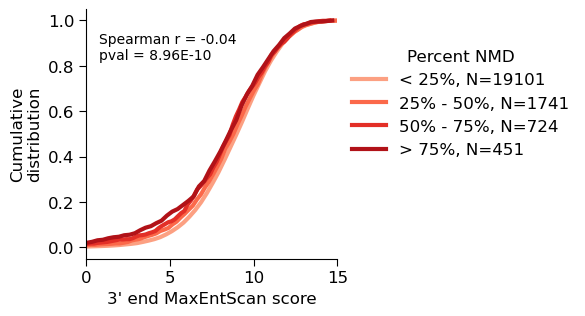

In [72]:
plt.rcParams['legend.title_fontsize'] = 12

colores = sns.color_palette("Reds", 5)
X, Y = plot_cumulative(np.array(df_5p.loc[(df_5p.NMD_ratio <= 0.25)].MES_5p))
N = len(np.array(df_5p.loc[(df_5p.NMD_ratio <= 0.25)].MES_5p))

X_, Y_ = plot_cumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.25) & (df_5p.NMD_ratio <= 0.5)].MES_5p))
N_ = len(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.25) & (df_5p.NMD_ratio <= 0.5)].MES_5p))

X__, Y__ = plot_cumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.5) & (df_5p.NMD_ratio <= 0.75)].MES_5p))
N__ = len(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.5) & (df_5p.NMD_ratio <= 0.75)].MES_5p))

X___, Y___ = plot_cumulative(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.75)].MES_5p))
N___ = len(np.array(df_5p.loc[(df_5p.NMD_ratio > 0.75)].MES_5p))

fig, ax = plt.subplots(figsize=(3.24, 3.24))

ax.plot(X, Y, c=colores[1], linewidth = 3, label='< 25%, N='+str(N))
ax.plot(X_, Y_, c=colores[2], linewidth = 3, label='25% - 50%, N='+str(N_))
ax.plot(X__, Y__, c=colores[3], linewidth = 3, label='50% - 75%, N='+str(N__))
ax.plot(X___, Y___, c=colores[4], linewidth = 3, label='> 75%, N='+str(N___))
ax.set_xlim([0, 15])
ax.legend(frameon=False, title='Percent NMD', bbox_to_anchor=(1, 0.9), fontsize=12)

# ax.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=12)

ax.set_xlabel("3' end MaxEntScan score", size=12)
ax.set_ylabel('Cumulative\ndistribution', size=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=12)


annotate_pval(df_5p.NMD_ratio, df_5p.MES_5p, ax, xy = (0.05, 0.8), col='black')

fig_dir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(fig_dir + 'Supplement_MaxEntScan_ThreePrime.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(fig_dir + 'Supplement_MaxEntScan_ThreePrime.png', dpi=300, bbox_inches='tight',)

# Percent from ranked junctions

In [23]:
expressed_genes = pd.read_csv('../code/ExpressionAnalysis/polyA/ExpressedGeneList.txt', sep ='\t',
                             names = ['chrom', 'start', 'end', 'gene', 'score', 'strand'])

expressed_genes.gene = [x.split('.')[0] for x in expressed_genes.gene]

In [24]:
long_table = long_table.loc[long_table.Dataset == 'chRNA.Expression.Splicing']

gene_total = pd.DataFrame(long_table.groupby(['gene', 'IndID']).Count.sum()).reset_index()
gene_total.columns = ['gene', 'IndID', 'gene_total']

gene_max = pd.DataFrame(long_table.groupby(['gene', 'IndID']).Count.max()).reset_index()
gene_max.columns = ['gene', 'IndID', 'gene_max']

long_table = long_table.merge(gene_total, left_on=['gene', 'IndID'], right_on=['gene', 'IndID']).merge(
    gene_max, left_on=['gene', 'IndID'], right_on=['gene', 'IndID']
)

long_table['PSI_total'] = long_table.Count/long_table.gene_total
long_table['PSI'] = long_table.Count/long_table.gene_max


In [25]:
long_table = long_table.loc[long_table.gene.isin(expressed_genes.gene)]

NMD = ['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene']
PC = ['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']

log2RPKM = RPKM[RPKM.columns.intersection(pd.Index(long_table.IndID.unique()))].median(axis=1).reset_index()
log2RPKM.columns = ['gene', 'RPKM']

In [26]:
nmd_counts = pd.DataFrame(
    long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby('gene').Count.sum())

idx = nmd_counts.index

pc_counts = pd.DataFrame(
    long_table.loc[long_table.SuperAnnotation.isin(PC)].groupby('gene').Count.sum()).reindex(idx).fillna(0)


psi = (nmd_counts.Count/(pc_counts.Count + nmd_counts.Count))



In [27]:
from scipy.stats import entropy

long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()
# long_summary = long_summary.merge(pd.DataFrame(
#     exon_counts.groupby(['gene', 'transcript']).exon_count.sum().reset_index().groupby('gene').exon_count.max()
# ), left_on='gene', right_index=True)

idx = psi.index

rank_list = []
gene_list = []
suma_list = []
intron_counts_list = []
entropy_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    if gene not in idx:
        continue
    
    suma = int(nmd_counts.loc[gene].Count)
    
    suma_list.append(suma)
    
#     intron_counts = list(df.exon_count)[0]
#     intron_counts_list.append(intron_counts)

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    entropy_ = entropy(rank_percent)
    entropy_list.append(entropy_)
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = np.sum(rank_percent[4:])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

df_summary = pd.DataFrame([suma_list, entropy_list]).T
df_summary.columns = ['total_reads', 'entropy']
df_summary.index = gene_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11586/11586 [00:07<00:00, 1564.28it/s]


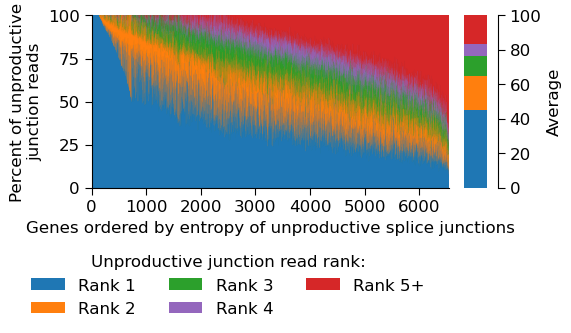

In [33]:
plt.rcParams['legend.title_fontsize'] = 12

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5.24, 2.24), gridspec_kw={'width_ratios': [8, 1], 
                                                                       'wspace': 0.02})

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.01)].index

top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()

df_idx = rank_.index

i = 0

df_rank_ = 100*df_rank.divide(df_rank.sum(axis=1), axis=0)

entropy_idx = df_summary.loc[df_idx].sort_values('entropy').index


for idx, row in df_rank_.loc[entropy_idx].iterrows():
    ax[0].plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    ax[0].plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
ax[0].set_xlabel('Genes ordered by entropy of unproductive splice junctions', size=12)
ax[0].set_ylabel('Percent of unproductive\njunction reads', size=12)

# ax[0].set_ylim([0, 100])
ax[0].margins(x=0, y=0)
# ax[0].set_xlim([0, i])
# ax[1].set_ylim([0, 100])

# ax[1].set_xlim([-0.25, 0.25])

# sns.despine(ax=ax[0], offset=0, trim=True)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

pd.DataFrame(df_rank_.loc[df_idx].mean(axis=0)).T.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'], ax=ax[1])

ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

# ax[1].set_ylabel('Average percent of\nunproductive reads', size=12)

ax[1].set_xticks([])
ax[1].legend(bbox_to_anchor=(-0.3, -0.3), frameon=False, title = 'Unproductive junction read rank:', fontsize=12, ncols=3)

ax[0].tick_params(length=5, labelsize=12)
ax[1].tick_params(length=5, labelsize=12)



ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

ax[1].set_ylabel('Average', size=12)
ax[1].margins(x=0, y=0)

# y = ax[1].secondary_yaxis('right')
# y.set_ticks([0, 20, 40, 60, 80, 100], ['0', '20', '40', '60', '80', '100'], fontsize=12)


fig_dir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(fig_dir + 'Read_ranks.100reads_1_to_20_percent_NMD.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(fig_dir + 'Read_ranks.100reads_1_to_20_percent_NMD.png', dpi=2000, bbox_inches='tight', transparent=True)

# Supplemental plots

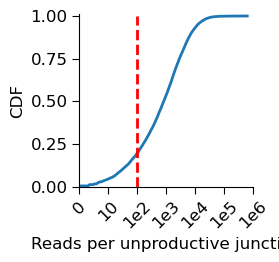

In [34]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

x = np.linspace(np.log10(long_summary.groupby('gene').Count.sum()).min(), 
                np.log10(long_summary.groupby('gene').Count.sum()).max(), 100)
y = [(np.log10(long_summary.groupby('gene').Count.sum()) <= z).mean() for z in x]
ax.plot(x, y, linewidth=2)
ax.set_xlabel('Reads per unproductive junction', size=12)
ax.set_ylabel('CDF', size=12)
# plt.xlim([-1, 51])
ax.set_xticks(range(7))
ax.set_xticklabels(['0', '10', '1e2', '1e3', '1e4', '1e5', '1e6'], size=12, rotation=45)
ax.plot([2, 2], [0, 1], 'r--', linewidth=2)
ax.set_xlim([0, 6])
ax.set_ylim([0, 1.01])
ax.tick_params(length=5, labelsize=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(fig_dir + 'NMD_reads_per_junction.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(fig_dir + 'NMD_reads_per_junction.png', dpi=300, bbox_inches='tight',)

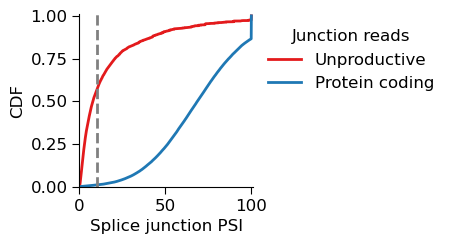

In [35]:
long_table_sum = long_table.groupby(['gene', 'symbol', 'junction', 'NewAnnotation', 'SuperAnnotation']
                                   ).Count.sum().reset_index()

gene_total_sum = pd.DataFrame(long_table_sum.groupby(['gene']).Count.max()).reset_index()
gene_total_sum.columns = ['gene',  'gene_max']

long_table_sum = long_table_sum.merge(gene_total_sum, left_on='gene', right_on='gene')
long_table_sum['PSI'] = long_table_sum.Count/long_table_sum.gene_max

long_table_sum_NMD = long_table_sum.loc[long_table_sum.SuperAnnotation.isin(NMD)]
long_table_sum_PC = long_table_sum.loc[long_table_sum.SuperAnnotation.isin(PC)]
x = np.linspace(0, 1, 1001)
contribution_NMD = [long_table_sum_NMD.loc[long_table_sum_NMD.PSI <= y].Count.sum() for y in x]
contribution_PC = [long_table_sum_PC.loc[long_table_sum_PC.PSI <= y].Count.sum() for y in x]

fig, ax = plt.subplots(figsize=(2.24, 2.24))

ax.plot(x*100, np.array(contribution_NMD)/np.max(contribution_NMD), label='Unproductive', c='#e31a1c', linewidth=2)
ax.plot(x*100, np.array(contribution_PC)/np.max(contribution_PC), label='Protein coding', c='#1f78b4', linewidth=2)
ax.plot([10, 10], [0, 100], linestyle='--', c='gray', linewidth=2)
ax.set_xlabel('Splice junction PSI', size=12)
ax.set_ylabel('CDF', size=12)
ax.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=12, title = 'Junction reads')

ax.set_xlim([0, 101])
ax.set_ylim([0, 1.01])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=12)

plt.savefig(fig_dir + 'NMD_junction_reads_per_gene_CDF.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fig_dir + 'NMD_junction_reads_per_gene_CDF.png', dpi=300, bbox_inches='tight')